# COMP5318 - Machine Learning and Data Mining 

## Tutorial 7 - Support Vector Machines (SVM)

**Semester 2, 2020**

**Objectives:**

* To learn about Support Vector Machines.

**Instructions:**
* Exercises to be completed on IPython notebook such as: 
   * Ipython 3 (Jupyter) notebook installed on your computer http://jupyter.org/install (you need to have Python installed first https://docs.python.org/3/using/index.html )
   * Web-based Ipython notebooks such as Google Colaboratory https://colab.research.google.com/ 
   
* If you are using Jupyter intalled on your computer, Go to File->Open. Drag and drop "lab7.ipynb" file to the home interface and click upload. 
* If you are using Google Colaboratory, Click File->Upload notebook, and and upload "lab7.ipynb" file
* Complete exercises in "lab7.ipynb".
* To run the cell you can press Ctrl-Enter or hit the Play button at the top.
* Complete all exercises marked with **TODO**.
* Save your file when you are done with the exercises, so you can show your tutor next week.


Lecturers: Nguyen Hoang Tran 

Tutors: Canh Dinh, Chen Chen, Claire Hardgrove, Fengxiang He, Henry Weld, Yixuan Zhang, Zhiyi Wang, Thomas Selvaraj.

## SVM

### Generate data

/Users/charlie/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:10: RuntimeWarning: covariance is not positive-semidefinite.
  # Remove the CWD from sys.path while we load stuff.
/Users/charlie/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:11: RuntimeWarning: covariance is not positive-semidefinite.
  # This is added back by InteractiveShellApp.init_path()


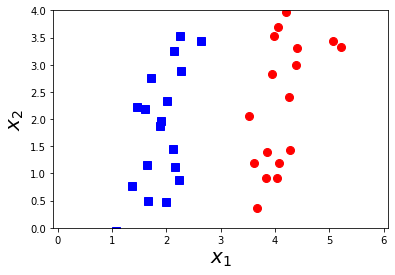

In [1]:
from __future__ import print_function
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
np.random.seed(22)

means = [[2, 2], [4, 2]]
cov = [[.3, 2], [.2, .3]]
N = 20
X0 = np.random.multivariate_normal(means[0], cov, N) # each row is a data point 
X1 = np.random.multivariate_normal(means[1], cov, N)
X = np.concatenate((X0, X1))
y = np.concatenate((np.ones(N), -np.ones(N)))

plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = 1)
plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = 1)
plt.axis('equal')
plt.ylim(0, 4)
plt.xlim(2, 4)
plt.xlabel('$x_1$', fontsize = 20)
plt.ylabel('$x_2$', fontsize = 20)
plt.show()

## 1. Solving SVM problem using Hinge Loss Function and Gradient Descent

### 1.1 Hinge Loss Function

Definition of Softmax function:
Input: $\textbf{x} \in \textbf{R}^{D}$

$$
\textbf{J}(w,b) = min_{\textbf{w},b} \sum_n max(0,1 - y_n [ \textbf{w}^T\textbf{x}_n +b ]) + \frac{\lambda}{2} ||\textbf{w}||^2 
$$

Can solve using gradient descent to get the optimal $w$ and $b$

### 1.2 Gradient of hinge loss function:

if $1-y_n[ \textbf{w}^T\textbf{x}_n +b] \geq 0$:
$$
\nabla \textbf{J}_w(w,b) = -y_n\textbf{x}_n + \lambda \textbf{w}
$$
$$
\nabla \textbf{J}_b(w,b) = -y_n
$$

else:

$$
\nabla \textbf{J}_w(w,b) = \lambda \textbf{w}
$$
$$
\nabla \textbf{J}_b(w,b) = 0
$$

In [2]:
print(X0.min(),X0.max())
print(X1.min(),X1.max())

-1.375783440638216 3.53647012950323
0.3713895898731101 5.207600973401832


In [3]:
C = 100
lam = 1./C

def loss(X, y, w, b): 
    """
    X.shape = (2N, d), y.shape = (2N,), w.shape = (d,), b is a scalar 
    """
    z = X.dot(w) + b # shape (2N,)
    yz = y*z
    return (np.sum(np.maximum(0, 1 - yz)) + .5*lam*w.dot(w))/X.shape[0] #TODO: Define the loss function

def grad(X, y, w, b):
    z = X.dot(w) + b # shape (2N,)
    yz = y*z         # element wise product, shape (2N,)
    active_set = np.where(yz <= 1)[0] # consider 1 - yz >= 0 only 
    _yX = - X*y[:, np.newaxis]   # each row is y_n*x_n 
    grad_w = (np.sum(_yX[active_set], axis = 0) + lam*w)/X.shape[0] #TODO Calculate gradient of w
    grad_b = (-np.sum(y[active_set]))/X.shape[0] #TODO Calculate gradient of b
    return (grad_w, grad_b)

def num_grad(X, y, w, b):
    eps = 1e-10
    gw = np.zeros_like(w)
    gb = 0
    for i in range(len(w)):
        wp = w.copy()
        wm = w.copy()
        wp[i] += eps 
        wm[i] -= eps 
        gw[i] = (loss(X, y, wp, b) - loss(X, y, wm, b))/(2*eps)
    gb = (loss(X, y, w, b + eps) - loss(X, y, w, b - eps))/(2*eps)
    return (gw, gb) 

In [4]:
w = .1*np.random.randn(X.shape[1])
b = np.random.randn()
(gw0, gb0) = grad(X, y, w, b)
(gw1, gb1) = num_grad(X, y, w, b)
print('grad_w difference = ', np.linalg.norm(gw0 - gw1))
print('grad_b difference = ', np.linalg.norm(gb0 - gb1))

grad_w difference =  6.196990040792852e-07
grad_b difference =  3.723316693848844e-08


In [5]:
def softmarginSVM_gd(X, y, w0, b0, eta):
    w = w0
    b = b0
    it = 0 
    while it < 10000:
        it = it + 1
        (gw, gb) = grad(X, y, w, b) #TODO Get gradient from grad function
        w -= eta*gw
        b -= eta*gb
        if (it % 1000) == 0:
            print('iter %d' %it + ' loss: %f' %loss(X, y, w, b))
    return (w, b)

w0 = .1*np.random.randn(X.shape[1]) 
b0 = .1*np.random.randn()
lr = 0.05
(w_hinge, b_hinge) = softmarginSVM_gd(X, y, w0, b0, lr)
print('w_hinge = ', w_hinge)
print('b_hinge = ', b_hinge)

iter 1000 loss: 0.011063
iter 2000 loss: 0.004553
iter 3000 loss: 0.000431
iter 4000 loss: 0.000431
iter 5000 loss: 0.000431
iter 6000 loss: 0.000431
iter 7000 loss: 0.000431
iter 8000 loss: 0.000431
iter 9000 loss: 0.000431
iter 10000 loss: 0.000431
w_hinge =  [-1.83298987  0.29475382]
b_hinge =  4.8463666553707005


In [6]:
def myplot(X0, X1, w, b, filename, tit):
    with PdfPages(filename) as pdf:
        fig, ax = plt.subplots()
        w0 = w[0]
        w1 = w[1]
        x1 = np.arange(-10, 10, 0.1)
        y1 = -w0/w1*x1 - b/w1
        y2 = -w0/w1*x1 - (b-1)/w1
        y3 = -w0/w1*x1 - (b+1)/w1
        plt.plot(x1, y1, 'k', linewidth = 3)
        plt.plot(x1, y2, 'k')
        plt.plot(x1, y3, 'k')

        # equal axis and lim
        plt.axis('equal')
        plt.ylim(0, 4)
        plt.xlim(2, 4)

        # hide ticks 
        cur_axes = plt.gca()
        cur_axes.axes.get_xaxis().set_ticks([])
        cur_axes.axes.get_yaxis().set_ticks([])

        plt.xlabel('$x_1$', fontsize = 20)
        plt.ylabel('$x_2$', fontsize = 20)
        plt.title('Solution: ' + tit, fontsize = 20)

        plt.plot(X0[:, 0], X0[:, 1], 'bs', markersize = 8, alpha = .8)
        plt.plot(X1[:, 0], X1[:, 1], 'ro', markersize = 8, alpha = .8)
        pdf.savefig()
        plt.show()

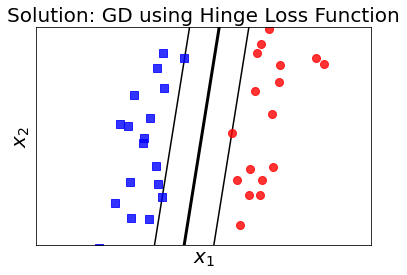

In [7]:
myplot(X0, X1, w_hinge, b_hinge, 'svm_hinge.pdf', 'GD using Hinge Loss Function')

## 2. Solving SVM problem using Lagrange Duality and KKT conditions

**Loss Function:**
$$
	\textbf{J}(w,b,\xi_n) = min_{\textbf{w},b,\xi} \frac{1}{2}||\textbf{w}||^2 + {C}\sum \xi_n
$$
$$
s.t. y_n [\textbf{w}^T\textbf{x}_n +b ] \geq 1 - \xi_n
$$ and $\xi_n \geq 0 $  while $C$ is constant and $ C> 0$

**Lagrangian:**

$$
L(\textbf{w},b,\{\xi_n\},\{\alpha_n\},\{\lambda_n\}) = {C}\sum \xi_n +  \frac{1}{2}||\textbf{w}||^2 - \sum_n \lambda_n \xi_n + \sum_n \alpha_n \{ 1- y_n [\textbf{w}^T\textbf{x}_n +b ] - \xi_n\}
$$

$$\alpha_n \geq 0,\lambda_n \geq 0$$

By taking derivatives of $L$ st $b$,$\xi_n$, $\textbf{w}$ respectively we have:
$$
\sum_n \alpha_ny_n = 0
$$
$$
C -\lambda_n - \alpha_n = 0
$$


**and the solution for w**:
$$
\textbf{w} = \sum_n \alpha_n y_n \textbf{x}_n
$$

**Using the dual problem to find $\alpha$:** 

$$
   max_{\alpha} g(\alpha_n, \lambda_n) = \sum \alpha_n - \frac{1}{2}\sum_{m,n}y_my_n\alpha_m\alpha_n\textbf{x}_m^T \textbf{x}_n
$$
$$
s.t. \alpha_n > 0 , \sum \alpha_ny_n = 0, C- \lambda_n - \alpha_n = 0,  \lambda_n \geq 0
$$
and KKT we have:

$\xi_n = 0$ and $0 < \alpha_n < C$ when $y_n [\textbf{w}^T\textbf{x}_n +b ] = 1$

$\xi_n > 0$ and $\alpha_n  = C$ if $y_n [\textbf{w}^T\textbf{x}_n +b ] < 1$ 

**Solution for b:**
$$
b = y_n - \sum_m \alpha_m y_m \textbf{x}_m^T \textbf{x}_n
$$

If $0 < \alpha_n < C$ and $y_n \in \{-1,1\}$

Please refer to https://xavierbourretsicotte.github.io/SVM_implementation.html for information about Solving a quadratic program using python

Assume that matrix:
$V = [y_1\textbf{x}_1,y_2\textbf{x}_2,...,y_n\textbf{x}_n]$ and $K = V^TV$ 

In [8]:
from cvxopt import matrix, solvers

# Step 1: Finding alpha 
V = np.concatenate((X0, -X1), axis = 0) # V[n,:] = y[n]*X[n]

# build K
K = matrix(V.dot(V.T))
p = matrix(-np.ones((2*N, 1)))

# build A, b, G, h 
G = matrix(np.vstack((-np.eye(2*N), np.eye(2*N))))
h = np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1))))
h = matrix(np.vstack((np.zeros((2*N, 1)), C*np.ones((2*N, 1)))))
A = matrix(y.reshape((-1, 2*N))) 
b = matrix(np.zeros((1, 1))) 
solvers.options['show_progress'] = False

#  solving the dual problem (finding: alpha)
sol = solvers.qp(K, p, G, h, A, b)
al = np.array(sol['x']).reshape(2*N) # alpha vector 

# Step 2: finding w and b using above solution
w_dual = al.dot(V) # shape (d,)
b_dual = np.mean(y - X.dot(w_dual)) # shape (1,)
print('w_dual = ', w_dual)
print('b_dual = ', b_dual)

w_dual =  [-1.82378858  0.29350924]
b_dual =  4.841354247678458


In [9]:
print(A)

[ 1.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00 ... ]



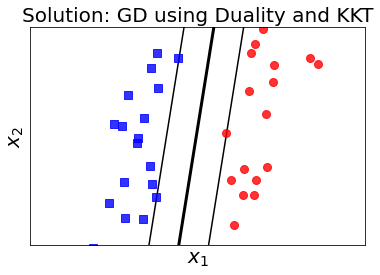

In [10]:
myplot(X0, X1, w_dual, b_dual, 'svm_b_dual.pdf', 'GD using Duality and KKT')

## 3. Solving by sklearn

In [11]:
from sklearn.svm import SVC
C = 100 # lambda = 0.01
clf = SVC(kernel = 'linear', C = C) #TODO: Using SVC from sklearn to find w and b
clf.fit(X, y) 

w_sklearn = clf.coef_.reshape(-1, 1)
b_sklearn = clf.intercept_[0]

print('w_sklearn = ', w_sklearn.T)
print('b_sklearn = ', b_sklearn)

w_sklearn =  [[-1.82321288  0.29341558]]
b_sklearn =  4.821600116082277


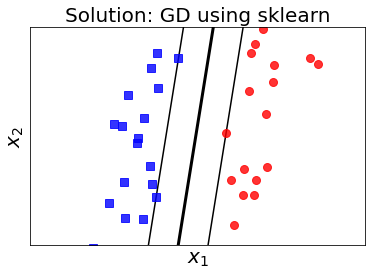

In [12]:
myplot(X0, X1, w_sklearn, b_sklearn, 'svm_b_sklearn.pdf', 'GD using sklearn')

## 4. Kernel SVM

Generate non-linear data

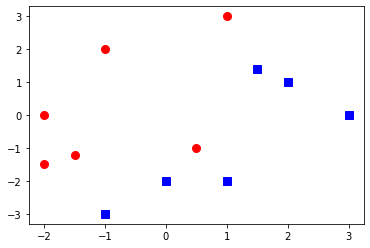

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

# XOR dataset and targets
X = np.c_[(-1, -3),
          (0, -2),
          (1, -2),
          (2, 1),
          (3, 0),
          (1.5, 1.4),
          #---
          (1, 3),
          (0.5, -1),
          (-1, 2),
          (-2, -1.5),
          (-2, 0),
          (-1.5, -1.2)].T
N = 6
Y = [0] * N + [1] * N

plt.plot(X[:N, 0], X[:N, 1], 'bs', markersize = 8)
plt.plot(X[N:, 0], X[N:, 1], 'ro', markersize = 8)
plt.axis('tight')
x_min = -5
x_max = 5
y_min = -5
y_max = 5

Observer the boundary using 3 Kernel Functions: Sigmoid, Polynomial of power, and rbf

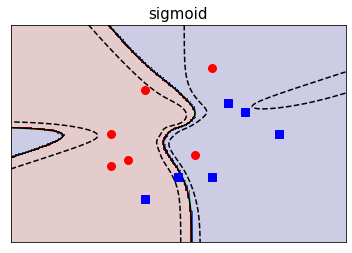

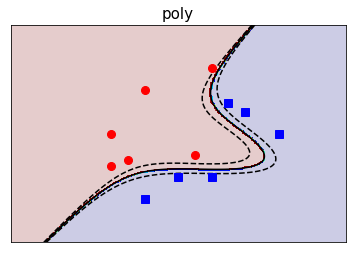

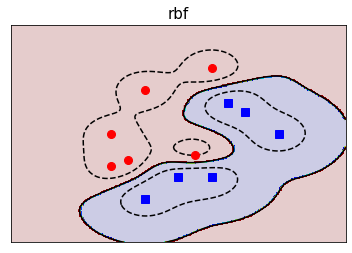

In [15]:
fignum = 1
# fit the model
for kernel in ('sigmoid', 'poly', 'rbf'):
    clf = svm.SVC(kernel=kernel, gamma=1, coef0 = 1)
    clf.fit(X, Y)
    # plot the line, the points, and the nearest vectors to the plane
    fig, ax = plt.subplots()
    plt.figure(fignum, figsize=(4, 3))
    plt.clf()
    plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=80,
                    facecolors='None')
    plt.plot(X[:N, 0], X[:N, 1], 'bs', markersize = 8)
    plt.plot(X[N:, 0], X[N:, 1], 'ro', markersize = 8)
    plt.axis('tight')
    x_min = -5
    x_max = 5
    y_min = -5
    y_max = 5
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(XX.shape)
    plt.figure(fignum, figsize=(4, 3))
    CS = plt.contourf(XX, YY, np.sign(Z), 200, cmap='jet', alpha = .2)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                    levels=[-.5, 0, .5])
    plt.title(kernel, fontsize = 15)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    fignum = fignum + 1
plt.show()